In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [3]:
# Upload eaf_data.zip
from google.colab import files
uploaded = files.upload()

# Unzip into a folder "eaf_data"
import zipfile, os
with zipfile.ZipFile('eaf_data.zip', 'r') as zf:
    zf.extractall('eaf_data')

# List files and directories in 'eaf_data' folder
import os
os.listdir('eaf_data')

Saving eaf_data.zip to eaf_data.zip


['lf_added_materials.csv',
 'inj_mat.csv',
 'ladle_tapping.csv',
 'eaf_temp.csv',
 'ferro.csv',
 'lf_initial_chemical_measurements.csv',
 'eaf_transformer.csv',
 'basket_charged.csv',
 'eaf_added_materials.csv',
 'eaf_final_chemical_measurements.csv',
 'eaf_gaslance_mat.csv']

In [4]:
local_path = 'eaf_data/'    # Enter folder name on your local directory here.

# Importing and Cleaning Data

EAF parameters info from Kaggle:

![image.png](attachment:image.png)

## Basket Charging Data (Ferrous Scrap + Fluxes)

In [5]:
df_basket_charged = pd.read_csv(local_path+'basket_charged.csv')    # Data for basket (bucket) charged materials, mainly ferrous scrap and fluxes.

df_basket_charged['CHARGED_AMOUNT'] = pd.to_numeric(df_basket_charged['CHARGED_AMOUNT'], errors='coerce')   # Change charge weights to numeric (values in kg).
df_basket_charged['DATETIME'] = pd.to_datetime(df_basket_charged['DATETIME'], errors='coerce')  # Change datetime to datetime.

df_basket_charged.head()    # For each heat (batch of liquid steel made in the EAF - identified by 'HEATID') there are several rows for the various types of material ('MAT_DEC').

/tmp/ipython-input-1878316840.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_basket_charged = pd.read_csv(local_path+'basket_charged.csv')    # Data for basket (bucket) charged materials, mainly ferrous scrap and fluxes.


,MAT_CODE,MAT_DEC,HEATID,DATETIME,CHARGED_AMOUNT
0,205051,3A,6F0020,2016-01-01 18:51:00,54071.0
1,205051,3A,6F0020,2016-01-01 19:24:00,75240.0
2,360258,In-house produced lime,6F0020,2016-01-01 18:33:00,2502.0
3,205051,3A,6F0020,2016-01-01 18:51:00,4773.0
4,360258,In-house produced lime,6F0020,2016-01-01 18:51:00,2500.0


In [6]:
df_basket_charged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137685 entries, 0 to 137684
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   MAT_CODE        137685 non-null  int64         
 1   MAT_DEC         137685 non-null  object        
 2   HEATID          137685 non-null  object        
 3   DATETIME        137685 non-null  datetime64[ns]
 4   CHARGED_AMOUNT  133339 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 5.3+ MB


In [7]:
df_basket_charged_heats = pd.pivot_table(df_basket_charged, values='CHARGED_AMOUNT', index='HEATID', columns=['MAT_DEC'], aggfunc='sum', fill_value=0)  # Pivot table to get charge weights on a per-heat basis. Fill value of 0 indicates none of that material was used.
df_basket_charged_heats.describe()  # Shows that data needs to be cleaned - some columns report 'negative' charge weights!

MAT_DEC,16A,25A,25A1,26A,3A,3A (shop pipe waste),3ACh,3B23,Aluminum briquet,Artificial graphite 0.1-2.5 mm,...,Scrap B23,Scrap G/B 25A,Scrap G/B 25AS,Secondary aluminum AV 87,Separation scrap,Separation waste 3A,Shram 75,Steel scrap G/B 25A,Steelmaking iron,Vanadium alloy
count,20806.000000,20806.000000,20806.000000,20806.000000,20806.000000,20806.0,20806.000000,20806.000000,20806.000000,20806.000000,...,20806.000000,20806.000000,20806.000000,20806.000000,20806.000000,20806.000000,20806.000000,20806.000000,20806.000000,20806.000000
mean,4810.282322,168.789099,1965.222196,9.822647,111989.239642,0.0,1825.980102,2.666490,0.009372,6.899452,...,29.809478,515.807315,118.941796,0.584158,25.466644,57.148563,2.609920,252.839854,797.275978,0.842017
std,4860.204639,973.551093,4552.243897,291.099222,27376.868911,0.0,7523.812337,146.951382,0.981031,76.241841,...,674.117034,1891.727924,786.762715,8.683088,476.057372,753.826745,343.537745,1639.247895,4085.710384,70.176209
min,0.000000,0.000000,-16967.000000,0.000000,-55612.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,108135.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4920.000000,0.000000,0.000000,0.000000,119762.500000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8503.000000,0.000000,0.000000,0.000000,127309.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,49366.000000,20854.000000,36268.000000,13890.000000,214225.000000,0.0,75137.000000,10052.000000,120.000000,1900.000000,...,31824.000000,21118.000000,11410.000000,240.000000,27316.000000,20490.000000,49300.000000,39590.000000,50550.000000,6010.000000


In [8]:
df_basket_charged_heats = df_basket_charged_heats[df_basket_charged_heats.ge(0).all(axis='columns') & df_basket_charged_heats.le(140000).all(axis='columns')]   # Filter out any heats where a negative weight was recorded, or where the charge weight was greater than the EAF total capacity of 140 tonnes
df_basket_charged_heats

MAT_DEC,16A,25A,25A1,26A,3A,3A (shop pipe waste),3ACh,3B23,Aluminum briquet,Artificial graphite 0.1-2.5 mm,...,Scrap B23,Scrap G/B 25A,Scrap G/B 25AS,Secondary aluminum AV 87,Separation scrap,Separation waste 3A,Shram 75,Steel scrap G/B 25A,Steelmaking iron,Vanadium alloy
HEATID,,,,,,,,,,,,,,,,,,,,,
5F0002,0.0,0.0,0.0,0.0,105928.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17560.0,0.0
5F0003,0.0,0.0,0.0,0.0,108033.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15320.0,0.0
5F0004,0.0,0.0,0.0,0.0,128245.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5F0005,0.0,0.0,0.0,0.0,106941.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16820.0,0.0
5F0006,0.0,0.0,0.0,0.0,127035.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8F5226,0.0,0.0,0.0,0.0,93327.0,0.0,10369.0,0.0,0.0,0.0,...,6043.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8F5227,0.0,0.0,0.0,0.0,91854.0,0.0,10628.0,0.0,0.0,0.0,...,6670.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8F5471,0.0,0.0,0.0,0.0,35528.0,0.0,52291.0,0.0,0.0,0.0,...,10423.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0


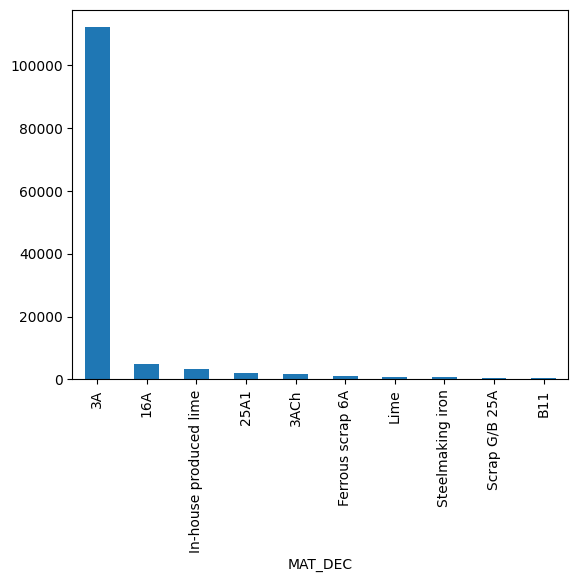

In [9]:
df_basket_charged_heats.mean()[df_basket_charged_heats.mean()>0].sort_values(ascending=False)[:10].plot.bar();

## Added Materials (Alloys)
This dataset appears to contain other materials charged to the EAF, mainly nonmetallic fluxes and alloying agents (e.g., carbon/coke, lime, magnesium-bearing material).

In [10]:
df_added_mats = pd.read_csv(local_path+'eaf_added_materials.csv')    # Data for alloy additions to the EAF at the start of the heat. This table is similar to the basket_charged file, and should be processed the same way.

df_added_mats['CHARGE_AMOUNT'] = pd.to_numeric(df_added_mats['CHARGE_AMOUNT'], errors='coerce') # Change to numeric (kg)
df_added_mats['DATETIME'] = pd.to_datetime(df_added_mats['DATETIME'], errors='coerce')  # Change to datetime

df_added_mats.info()    # For each heat (batch of liquid steel made in the EAF - identified by 'HEATID') there are several rows for the various types of material ('MAT_DEC').

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79944 entries, 0 to 79943
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   MAT_CODE       79944 non-null  int64         
 1   MAT_DEC        79944 non-null  object        
 2   HEATID         79944 non-null  object        
 3   DATETIME       79944 non-null  datetime64[ns]
 4   CHARGE_AMOUNT  79893 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 3.0+ MB


In [11]:
df_added_mats_heats = pd.pivot_table(df_added_mats, values='CHARGE_AMOUNT', index='HEATID', columns=['MAT_DEC'], aggfunc='sum', fill_value=0)  # Pivot table to get charge weights on a per-heat basis. Fill value of 0 indicates none of that material was used.
df_added_mats_heats.describe()  # Shows that data needs to be cleaned - some columns report 'negative' charge weights! Furthermore, many 'MAT_DEC' from this table are shared with the 'basket_charged' table, except the quantities here are much smaller.

MAT_DEC,25A,25A1,3A,3ACh,AShM 75,Aluminum briquet,Anthracite,Artificial graphite 0.1-2.5 mm,B68,Briquet BMK-60,...,MnSi17A,Mo pellets,Pellets AV-87,SIMP-RM,Scrap G/B 25A,Scrap G/B 25AS,Secondary aluminum AV 87,Separation waste 3A,Steel scrap G/B 25A,Steelmaking iron
count,20506.000000,20506.000000,20506.000000,20506.000000,20506.000000,20506.000000,20506.000000,20506.000000,20506.000000,20506.000000,...,20506.000000,20506.000000,20506.000000,20506.000000,20506.000000,20506.000000,20506.000000,20506.0,20506.000000,20506.000000
mean,1.973569,-6.646347,16.502487,2.557495,0.121916,0.029845,0.646104,1.414220,0.041695,0.333415,...,5.974203,0.201502,-0.051107,0.511606,0.408661,0.257973,3.384083,0.0,6.637569,-2.326148
std,141.415085,472.845809,1709.215160,237.098215,17.458203,1.748985,25.527495,38.541432,5.970705,13.254520,...,79.376153,15.216518,7.318479,10.366453,58.519896,36.941557,169.001115,0.0,396.090764,205.718567
min,0.000000,-28380.000000,-84210.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1048.000000,-300.000000,0.000000,0.000000,-100.000000,0.0,-9950.000000,-20340.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,10640.000000,29520.000000,136670.000000,29940.000000,2500.000000,111.000000,1699.000000,1500.000000,855.000000,558.000000,...,2500.000000,1358.000000,0.000000,1270.000000,8380.000000,5290.000000,24000.000000,0.0,20910.000000,0.000000


In [12]:
df_added_mats_heats = df_added_mats_heats[df_added_mats_heats.ge(0).all(axis='columns') & df_added_mats_heats.le(140000).all(axis='columns')]   # Filter out any heats where a negative weight was recorded, or where the charge weight was greater than the EAF total capacity of 140 tonnes
df_added_mats_heats

MAT_DEC,25A,25A1,3A,3ACh,AShM 75,Aluminum briquet,Anthracite,Artificial graphite 0.1-2.5 mm,B68,Briquet BMK-60,...,MnSi17A,Mo pellets,Pellets AV-87,SIMP-RM,Scrap G/B 25A,Scrap G/B 25AS,Secondary aluminum AV 87,Separation waste 3A,Steel scrap G/B 25A,Steelmaking iron
HEATID,,,,,,,,,,,,,,,,,,,,,
5F0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5F0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5F0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5F0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5F0006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8F5227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8F5392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8F5471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


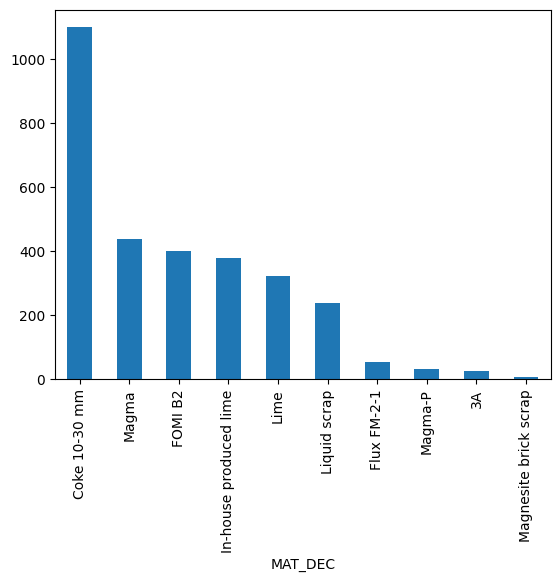

In [13]:
df_added_mats_heats.mean()[df_added_mats_heats.mean()>0].sort_values(ascending=False)[:10].plot.bar();

## Liquid Steel Chemistry
Chemical analysis for final liquid steel bath in the EAF.

In [14]:
df_steel_chem = pd.read_csv(local_path+'eaf_final_chemical_measurements.csv', decimal=',')    # Data for chemical analysis of final steel. The dataset may originate from Europe as ',' is used for decimals.

for col in df_steel_chem.columns[3:]:
    df_steel_chem[col] = pd.to_numeric(df_steel_chem[col], errors='coerce') # Change to numeric (%)

df_steel_chem['DATETIME'] = pd.to_datetime(df_steel_chem['DATETIME'], errors='coerce')  # Change to datetime

df_steel_chem.info()    # For each heat (batch of liquid steel made in the EAF - identified by 'HEATID') there are several rows for the various types of material ('MAT_DEC').

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3709 entries, 0 to 3708
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   HEATID       3709 non-null   object        
 1   POSITIONROW  3709 non-null   int64         
 2   DATETIME     3709 non-null   datetime64[ns]
 3   VALC         3341 non-null   float64       
 4   VALSI        3341 non-null   float64       
 5   VALMN        3341 non-null   float64       
 6   VALP         3340 non-null   float64       
 7   VALS         3341 non-null   float64       
 8   VALCU        3341 non-null   float64       
 9   VALCR        3341 non-null   float64       
 10  VALMO        3341 non-null   float64       
 11  VALNI        3341 non-null   float64       
 12  VALAS        3341 non-null   float64       
 13  VALSN        3340 non-null   float64       
 14  VALN         2417 non-null   float64       
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)


In [15]:
df_steel_chem.set_index('HEATID', inplace=True)
df_steel_chem.head()

,POSITIONROW,DATETIME,VALC,VALSI,VALMN,VALP,VALS,VALCU,VALCR,VALMO,VALNI,VALAS,VALSN,VALN
HEATID,,,,,,,,,,,,,,
6F0037,1,2016-01-02 11:02:00,0.0545,0.0197,0.0632,0.0040,0.0210,0.2145,0.0504,0.0165,0.1307,0.0064,0.0209,0.0124
6F0042,1,2016-01-02 15:22:00,0.0692,0.0167,0.0598,0.0042,0.0158,0.2278,0.0864,0.0166,0.1684,0.0064,0.0072,0.0110
6F0045,1,2016-01-02 18:05:00,0.0558,0.0169,0.0666,0.0053,0.0203,0.2315,0.1100,0.0176,0.1790,0.0063,0.0107,0.0105
6F0096,1,2016-01-04 17:30:00,0.0620,0.0156,0.0811,0.0046,0.0211,0.1677,0.0596,0.0112,0.0948,0.0061,0.0055,0.0118
6F0098,1,2016-01-04 19:19:00,0.0501,0.0144,0.0604,0.0054,0.0251,0.1850,0.0448,0.0111,0.1033,0.0064,0.0061,0.0133


<Axes: >

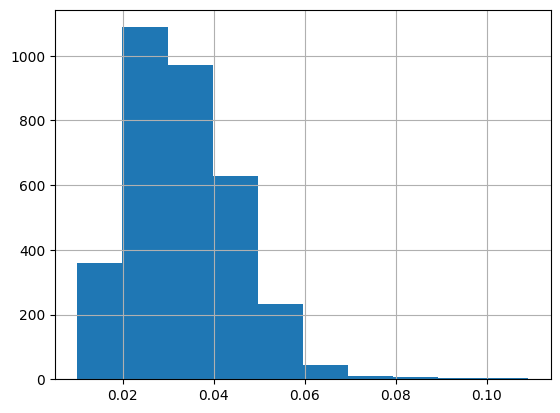

In [16]:
df_steel_chem['VALS'].hist()    # For fun, plot histogram of sulfur analysis. Sulfur is an important alloy/contaminant of raw steel.

# Liquid Steel Temperature
Contains tapping temperature and dissolved oxygen data.

In [17]:
df_steel_temp = pd.read_csv(local_path+'eaf_temp.csv', decimal=',')    # Data for temperature of final steel. ',' is used for decimals.

for col in df_steel_temp.columns[2:]:
    df_steel_temp[col] = pd.to_numeric(df_steel_temp[col], errors='coerce') # Change to numeric

df_steel_temp['DATETIME'] = pd.to_datetime(df_steel_temp['DATETIME'], errors='coerce')  # Change to datetime

df_steel_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85104 entries, 0 to 85103
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   HEATID     85104 non-null  object        
 1   DATETIME   85104 non-null  datetime64[ns]
 2   TEMP       85104 non-null  float64       
 3   VALO2_PPM  85104 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.6+ MB


In [18]:
df_steel_temp.set_index('HEATID', inplace=True)
df_steel_temp.head()    # There are duplicated HEATID's - because there are multiple temperature and O2 measurements at the end of the heat.

,DATETIME,TEMP,VALO2_PPM
HEATID,,,
6F0020,2016-01-01 19:15:00,1650.0,1242.0
6F0021,2016-01-01 20:05:00,1649.0,1160.0
6F0021,2016-01-01 20:05:00,1649.0,1160.0
6F0021,2016-01-01 20:03:00,1606.0,1152.0
6F0022,2016-01-01 21:03:00,1636.0,947.0


In [19]:
df_steel_temp.replace(0, np.nan, inplace=True)    # Impute 0 with nan as there was no measurement (impossible to have 0 temp or oxygen content)
df_steel_temp = df_steel_temp.groupby('HEATID').mean()  # Aggregate to HEATID's by calculating the mean
df_steel_temp

,DATETIME,TEMP,VALO2_PPM
HEATID,,,
5F0002,2015-01-01 01:31:00.000000000,1627.000000,383.000000
5F0003,2015-01-01 02:17:30.000000000,1641.000000,683.000000
5F0004,2015-01-01 03:17:30.000000000,1636.000000,700.000000
5F0005,2015-01-01 04:06:00.000000000,1630.000000,625.333333
5F0006,2015-01-01 04:54:24.000000000,1622.000000,654.600000
...,...,...,...
8F5227,2018-07-20 06:34:30.000000000,1624.750000,584.666667
8F5392,2018-07-25 21:40:15.789473792,1649.315789,168.000000
8F5471,2018-07-29 07:37:00.000000000,1630.000000,731.400000


<Axes: >

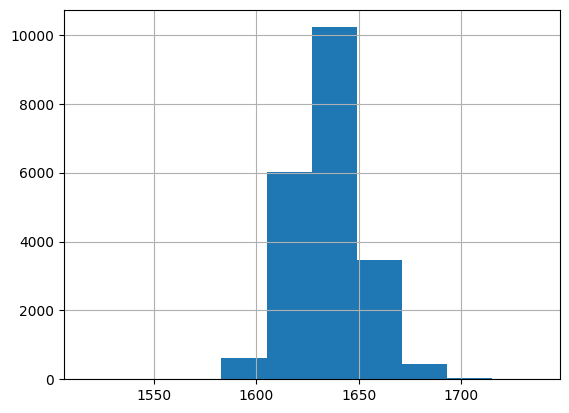

In [20]:
df_steel_temp['TEMP'].hist()    # Histogram of steel temperature - critical KPI for any meltshop.

# EAF Gas Lance (Injected Gaseous Fuels/Reagents)
This dataset has information on natural gas ('gas') and oxygen which are injected into the furnace as a fuel to help melt the scrap, as well as a reagent to control the carbon content of the steel.

In [21]:
df_gaslance = pd.read_csv(local_path+'eaf_gaslance_mat.csv', decimal=',', parse_dates=True)    # Data for temperature of final steel. ',' is used for decimals.

df_gaslance['REVTIME'] = pd.to_datetime(df_gaslance['REVTIME'], format="%Y-%m-%d %H:%M:%S,%f", errors='coerce')
df_gaslance = df_gaslance.sort_values(by='REVTIME') # Make sure all data is sorted by the logged time.

df_gaslance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5748194 entries, 3825874 to 3825873
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   REVTIME     datetime64[ns]
 1   O2_AMOUNT   float64       
 2   GAS_AMOUNT  float64       
 3   O2_FLOW     float64       
 4   GAS_FLOW    float64       
 5   HEATID      object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 307.0+ MB


In [22]:
df_gaslance_heats = df_gaslance.groupby('HEATID').tail(1)   # The total oxygen and gas volume is recorded cumulatively during a heat. Grabbing the tail(1) gives only the last reading, which should be t he total amount during the heat.
df_gaslance_heats.set_index('HEATID', inplace=True)
df_gaslance_heats.drop(columns=['O2_FLOW', 'GAS_FLOW'], inplace=True) # Drop these ones as they are not integrated (i.e., meaningless when aggregated)
df_gaslance_heats.head()

/tmp/ipython-input-2384578899.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gaslance_heats.drop(columns=['O2_FLOW', 'GAS_FLOW'], inplace=True) # Drop these ones as they are not integrated (i.e., meaningless when aggregated)


,REVTIME,O2_AMOUNT,GAS_AMOUNT
HEATID,,,
5F0002,2015-01-01 01:37:37.664,3659.0,1160.0
5F0003,2015-01-01 02:22:47.492,3469.0,1117.0
5F0004,2015-01-01 03:24:12.680,3605.0,1204.0
5F0005,2015-01-01 04:12:55.117,3678.0,1191.0
5F0006,2015-01-01 05:01:37.617,3655.0,1171.0


# EAF Injectants
This dataset contains information about injected carbon (usually coal) - carbon injection is used to generate gases that help refine the steel bath and form a 'foamy slag' which enhances electric arc heat transfer.

In [23]:
df_injectant = pd.read_csv(local_path+'inj_mat.csv', decimal=',', parse_dates=True)    # Data for injectants.

df_injectant['REVTIME'] = pd.to_datetime(df_injectant['REVTIME'], format="%Y-%m-%d %H:%M:%S,%f", errors='coerce')
df_injectant = df_injectant.sort_values(by='REVTIME') # Make sure all data is sorted by the logged time.

df_injectant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4011646 entries, 2567496 to 2567495
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   REVTIME            datetime64[ns]
 1   INJ_AMOUNT_CARBON  float64       
 2   INJ_FLOW_CARBON    float64       
 3   HEATID             object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 153.0+ MB


In [24]:
df_injectant_heats = df_injectant.groupby('HEATID').tail(1)
df_injectant_heats.set_index('HEATID', inplace=True)
df_injectant_heats.drop(columns=['INJ_FLOW_CARBON'], inplace=True) # Drop these ones as they are not integrated (i.e., meaningless when aggregated)
df_injectant_heats.head()

/tmp/ipython-input-3655019827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_injectant_heats.drop(columns=['INJ_FLOW_CARBON'], inplace=True) # Drop these ones as they are not integrated (i.e., meaningless when aggregated)


,REVTIME,INJ_AMOUNT_CARBON
HEATID,,
5F0002,2015-01-01 01:37:37.633,1021.0
5F0003,2015-01-01 02:22:47.461,957.0
5F0004,2015-01-01 03:24:12.664,789.0
5F0005,2015-01-01 04:12:55.101,812.0
5F0006,2015-01-01 05:01:37.601,882.0


# Transformer/Electrical Data
This dataset provides data from the electrical supply system, which allows us to calculate the energy consumption of the process.

In [25]:
df_transformer = pd.read_csv(local_path+'eaf_transformer.csv', decimal=',', parse_dates=True)    # Electrical data.

df_transformer['STARTTIME'] = pd.to_datetime(df_transformer['STARTTIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_transformer = df_transformer.sort_values(by='STARTTIME') # Make sure all data is sorted by the logged time.

df_transformer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271712 entries, 180214 to 180210
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   TAP        271712 non-null  int64         
 1   HEATID     271712 non-null  object        
 2   STARTTIME  271712 non-null  datetime64[ns]
 3   DURATION   271712 non-null  object        
 4   MW         271712 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 12.4+ MB


In [26]:
df_transformer_heats = pd.DataFrame(df_transformer.set_index('HEATID')['MW'].groupby('HEATID').sum())    # Checking the 'MW' column. Based on the value, it seems the column actually refers to the MWh of energy (not units of power!!!) used. So, we will not need to manually integrate to get the power.
df_transformer_heats.head()

,MW
HEATID,
5F0002,48.625
5F0003,48.625
5F0004,47.375
5F0005,49.250
5F0006,49.875


# Merging Data and Getting Design Matrix
Merge all the processed datasets to get the design matrix. The final column 'MW' is the target variable.

In [27]:
df_transformer_heats

,MW
HEATID,
5F0002,48.625
5F0003,48.625
5F0004,47.375
5F0005,49.250
5F0006,49.875
...,...
8F5226,49.500
8F5227,51.250
8F5471,49.500


In [28]:
df_design = df_basket_charged_heats.join(
    df_added_mats_heats,
    on='HEATID',
    rsuffix=' Added'
).join(
    df_steel_chem.drop(columns=['POSITIONROW', 'DATETIME']),    # Drop redundane rows (no data in POSITIONROW, and we will get DATETIME elsewhere)
    on='HEATID'
).join(
    df_steel_temp,   # Do not drop the datetime, as we will consider the DATETIME of the chemical test to be the 'true' finish time for the heat
    on='HEATID'
).join(
    df_gaslance_heats.drop(columns=['REVTIME']),
    on='HEATID'
).join(
    df_injectant_heats.drop(columns=['REVTIME']),
    on='HEATID'
).join(
    df_transformer_heats,
    on='HEATID'
)

df_design.head()    # This is the full design matrix. The final column 'MW' is the target (y) which is the amount of energy (in MWh) used to make that heat of steel.

,16A,25A,25A1,26A,3A,3A (shop pipe waste),3ACh,3B23,Aluminum briquet,Artificial graphite 0.1-2.5 mm,...,VALAS,VALSN,VALN,DATETIME,TEMP,VALO2_PPM,O2_AMOUNT,GAS_AMOUNT,INJ_AMOUNT_CARBON,MW
HEATID,,,,,,,,,,,,,,,,,,,,,
5F0002,0.0,0.0,0.0,0.0,105928.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2015-01-01 01:31:00,1627.0,383.000000,3659.0,1160.0,1021.0,48.625
5F0003,0.0,0.0,0.0,0.0,108033.0,0.0,0.0,0.0,0.0,0.0,...,0.0053,0.0068,0.0361,2015-01-01 02:17:30,1641.0,683.000000,3469.0,1117.0,957.0,48.625
5F0004,0.0,0.0,0.0,0.0,128245.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2015-01-01 03:17:30,1636.0,700.000000,3605.0,1204.0,789.0,47.375
5F0005,0.0,0.0,0.0,0.0,106941.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2015-01-01 04:06:00,1630.0,625.333333,3678.0,1191.0,812.0,49.250
5F0006,0.0,0.0,0.0,0.0,127035.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2015-01-01 04:54:24,1622.0,654.600000,3655.0,1171.0,882.0,49.875


<Axes: >

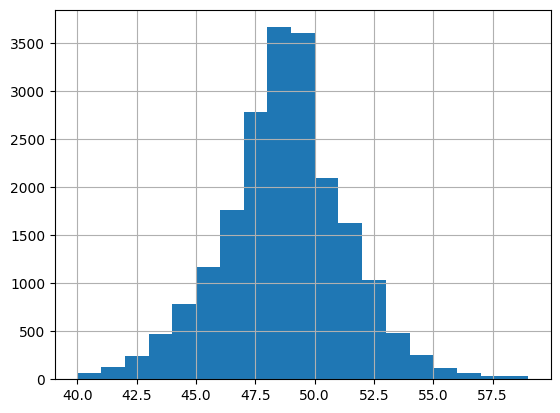

In [29]:
# Histogram for the target variable (‘MW’)
df_design['MW'].hist(
    bins = np.arange(40, 60, 1)
)

In [30]:
df_design.to_csv('design_matrix_ver_0.csv') # Save matrix to path for future use.

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
df_design.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20747 entries, 5F0002 to 8F5473
Columns: 112 entries, 16A to MW
dtypes: datetime64[ns](1), float64(111)
memory usage: 18.4+ MB


In [33]:
# Build BASKET_TOTAL(One of the Key Feature)

# Calculate total basket charge amount per HeatID
df_design["BASKET_TOTAL"] = df_basket_charged_heats.sum(axis=1)

In [34]:
# Check missing value
df_design[['MW', 'O2_AMOUNT', 'GAS_AMOUNT', 'INJ_AMOUNT_CARBON', 'BASKET_TOTAL']].isna().sum()


,0
MW,9
O2_AMOUNT,0
GAS_AMOUNT,0
INJ_AMOUNT_CARBON,0
BASKET_TOTAL,0


Summary statistics for MW:
count    20738.000000
mean        48.456873
std         10.468258
min       -999.999000
25%         47.000000
50%         48.750000
75%         50.250000
max        999.999000
Name: MW, dtype: float64


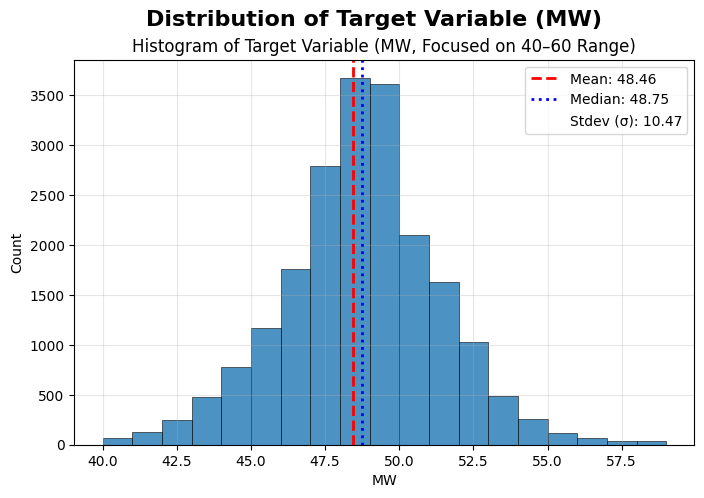

In [35]:
# Fig 1: Distribution of Target Variable (MW)

# Select target column (MW)
target_col = "MW"
target_vals = df_design[target_col].dropna().astype(float)

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Distribution of Target Variable (MW)', fontsize=16, fontweight='bold')

# Plot histogram (range limited to 40–60 for focus)
ax.hist(target_vals, bins=np.arange(40, 60, 1), alpha=0.8, edgecolor='black', linewidth=0.5)

# Add mean, median and standard deviation
mean_val = target_vals.mean()
median_val = target_vals.median()
std_val = target_vals.std()

ax.axvline(mean_val, color='red', linestyle='--', linewidth=2,
           label=f'Mean: {mean_val:.2f}')
ax.axvline(median_val, color='blue', linestyle=':', linewidth=2,
           label=f'Median: {median_val:.2f}')
ax.plot([], [], ' ', label=f'Stdev (σ): {std_val:.2f}')


# Titles, labels, legend
ax.set_xlabel('MW')
ax.set_ylabel('Count')
ax.set_title('Histogram of Target Variable (MW, Focused on 40–60 Range)')
ax.legend()
ax.grid(True, alpha=0.3)

# Print summary statistics
print("Summary statistics for MW:")
print(df_design["MW"].describe())

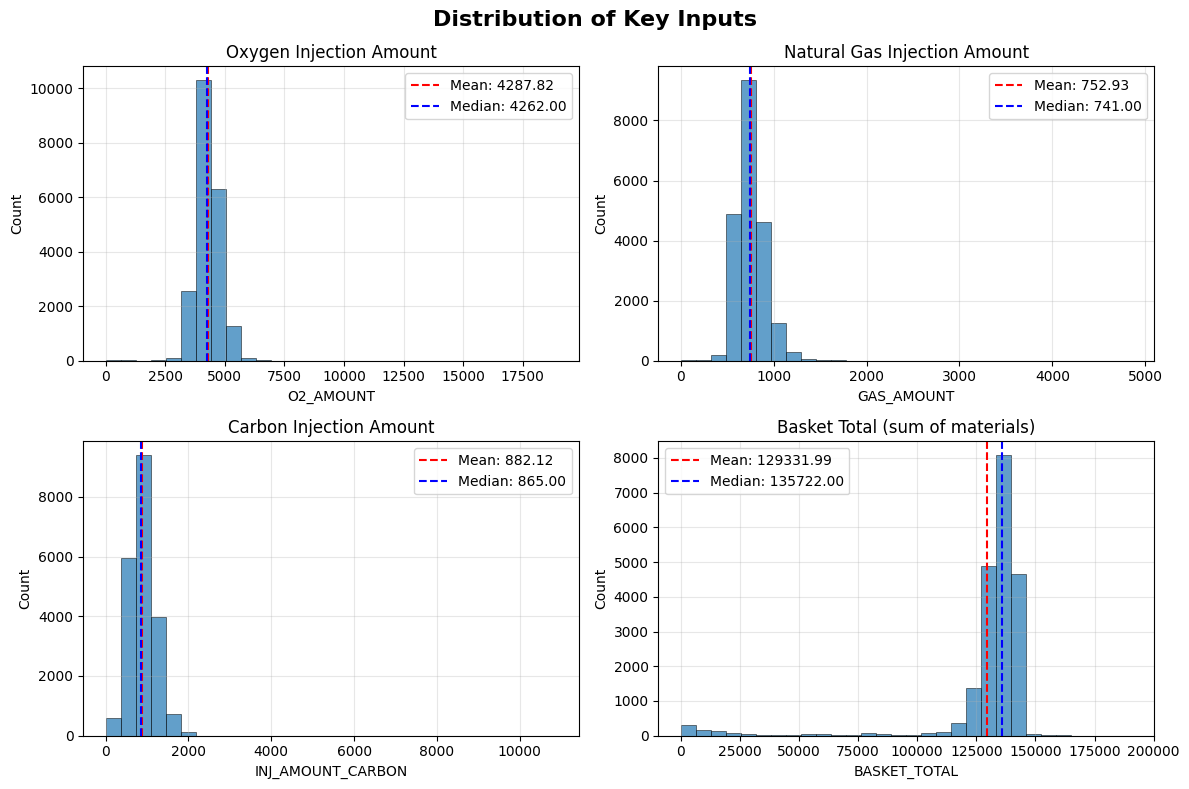

In [36]:
# Fig 2: Distribution of Key Features: O2 total, NG total, Carbon injection, Basket Total

# Define the 4 key features to plot
features_to_plot = [
    ('O2_AMOUNT',           'Oxygen Injection Amount'),
    ('GAS_AMOUNT',          'Natural Gas Injection Amount'),
    ('INJ_AMOUNT_CARBON',   'Carbon Injection Amount'),
    ('BASKET_TOTAL',        'Basket Total (sum of materials)'),
]

# Create 2×2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distribution of Key Inputs', fontsize=16, fontweight='bold')

for i, (col, display_name) in enumerate(features_to_plot):
    row = i // 2
    colpos = i % 2

    # Select data
    vals = df_design[col].dropna().astype(float)

    # Create histogram
    axes[row, colpos].hist(vals, bins=30, alpha=0.7,
                           edgecolor='black', linewidth=0.5)

    # Add mean & median
    mean_val = vals.mean()
    median_val = vals.median()
    axes[row, colpos].axvline(mean_val, color='red', linestyle='--',
                              label=f'Mean: {mean_val:.2f}')
    axes[row, colpos].axvline(median_val, color='blue', linestyle='--',
                              label=f'Median: {median_val:.2f}')

    # Titles / labels
    axes[row, colpos].set_title(f'{display_name}')
    axes[row, colpos].set_xlabel(col)
    axes[row, colpos].set_ylabel('Count')
    axes[row, colpos].legend()
    axes[row, colpos].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


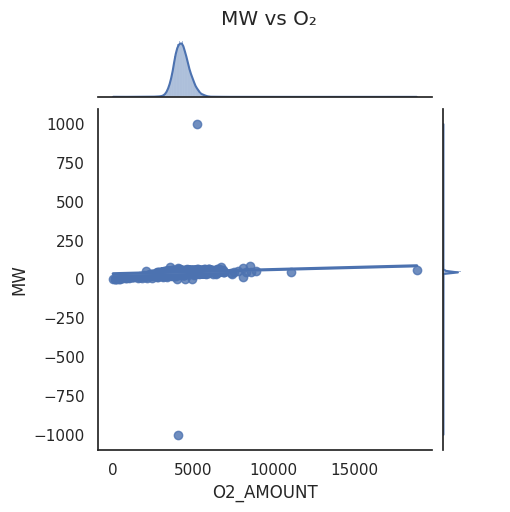

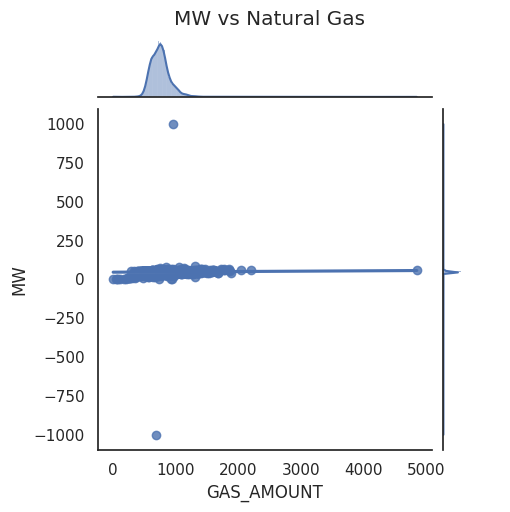

In [37]:
# Fig 3: Joint distributions (Target vs O2) | (Target vs NG)

sns.set(style="white")  # simple clean style

# 3a: MW vs O2
g1 = sns.jointplot(data=df_design, x='O2_AMOUNT', y='MW', kind='reg', height=5)
g1.fig.suptitle('MW vs O₂', y=1.02)  # title a little above
g1.savefig('Fig_2_2_1_jointplot_MW_vs_O2.png', dpi=160)
plt.show()

# 3b: MW vs NG
g2 = sns.jointplot(data=df_design, x='GAS_AMOUNT', y='MW', kind='reg', height=5)
g2.fig.suptitle('MW vs Natural Gas', y=1.02)
g2.savefig('Fig_2_2_1_jointplot_MW_vs_NG.png', dpi=160)
plt.show()

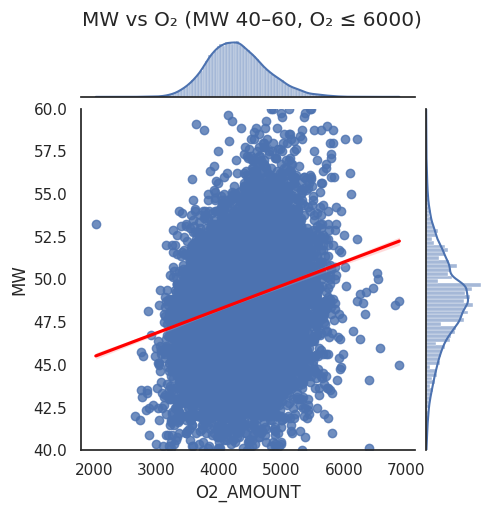

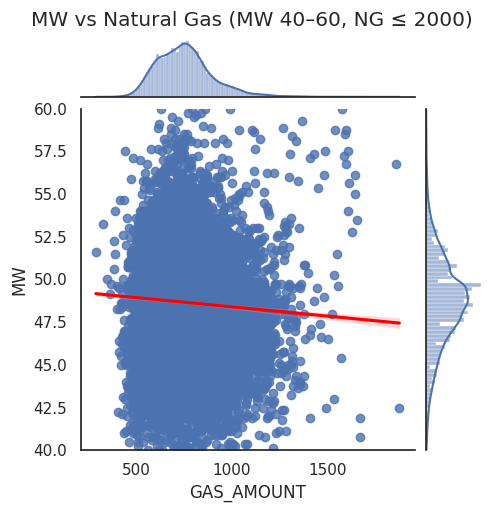

In [38]:
# Fig 3: Joint distributions (Target vs O2) | (Target vs NG)

sns.set(style="white")  # simple clean style

# 3a: MW vs O2
f1 = df_design[(df_design['MW'].between(40, 60)) & (df_design['O2_AMOUNT'] <= 7000)]
g1 = sns.jointplot(data=f1, x='O2_AMOUNT', y='MW', kind='reg', height=5, line_kws={'color': 'red'})
g1.fig.suptitle('MW vs O₂ (MW 40–60, O₂ ≤ 6000)', y=1.02)
g1.ax_joint.set_ylim(40, 60)
plt.show()

# 3b: MW vs NG
f2 = df_design[(df_design['MW'].between(40, 60)) & (df_design['GAS_AMOUNT'] <= 3000)]
g2 = sns.jointplot(data=f2, x='GAS_AMOUNT', y='MW', kind='reg', height=5, line_kws={'color': 'red'})
g2.fig.suptitle('MW vs Natural Gas (MW 40–60, NG ≤ 2000)', y=1.02)
g2.ax_joint.set_ylim(40, 60)
plt.show()

Correlation Matrix for Key Inputs and Target (MW):
                      MW  O2_AMOUNT  GAS_AMOUNT  INJ_AMOUNT_CARBON  \
MW                 1.000      0.134       0.033              0.049   
O2_AMOUNT          0.134      1.000       0.164              0.181   
GAS_AMOUNT         0.033      0.164       1.000              0.124   
INJ_AMOUNT_CARBON  0.049      0.181       0.124              1.000   
BASKET_TOTAL       0.038      0.065       0.048              0.114   

                   BASKET_TOTAL  
MW                        0.038  
O2_AMOUNT                 0.065  
GAS_AMOUNT                0.048  
INJ_AMOUNT_CARBON         0.114  
BASKET_TOTAL              1.000  


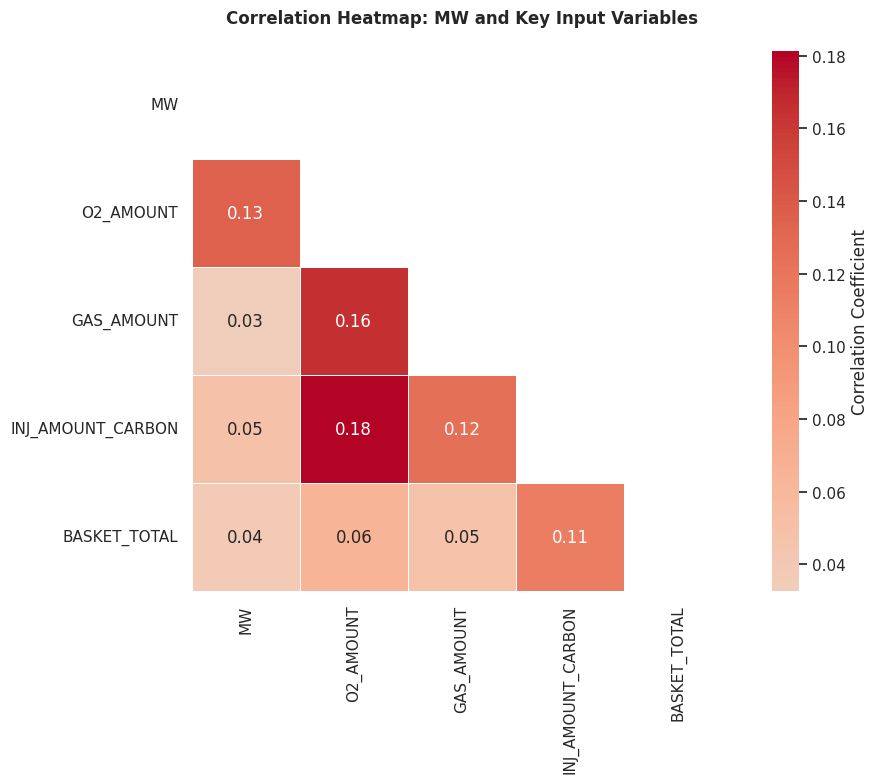

In [39]:
# Fig 4：Correlation Analysis

# Define variables to include in correlation analysis
corr_cols = ['MW', 'O2_AMOUNT', 'GAS_AMOUNT', 'INJ_AMOUNT_CARBON', 'BASKET_TOTAL']

# Calculate correlation matrix
correlation_matrix = df_design[corr_cols].corr()

# Display correlation matrix
print("Correlation Matrix for Key Inputs and Target (MW):")
print(correlation_matrix.round(3))

# Create correlation heatmap
plt.figure(figsize=(10, 8))

# Mask upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Draw heatmap
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})

# Add title and adjust layout
plt.title('Correlation Heatmap: MW and Key Input Variables', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

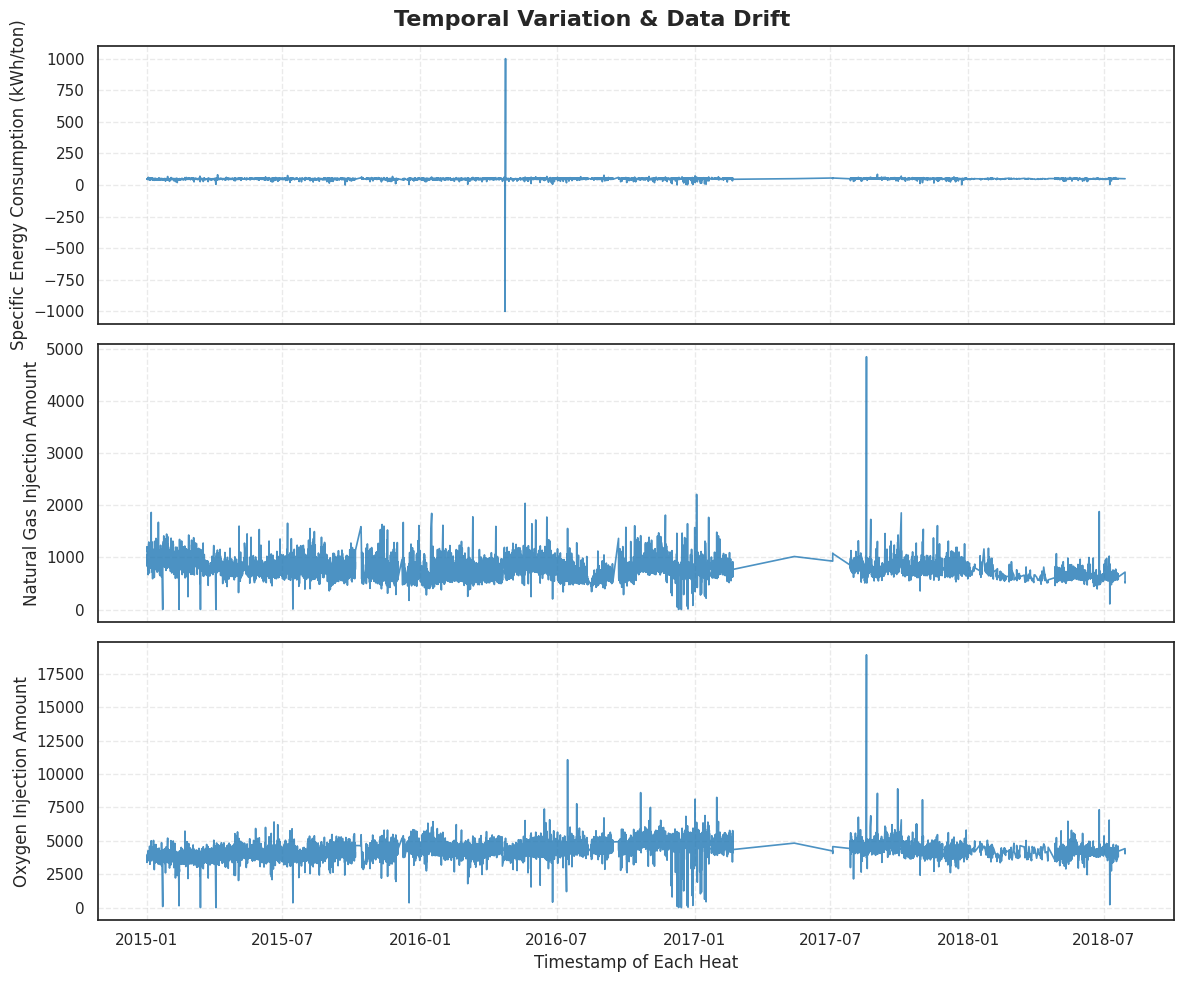

In [40]:
# ===================== Temporal Variation & Data Drift =====================
# Plot how SEC, GAS_AMOUNT, and O2_AMOUNT change over time

import matplotlib.pyplot as plt

# Sort by timestamp to ensure correct time order
df_design_sorted = df_design.sort_values(by='DATETIME')  # replace with actual time column name

# Define variables to visualize
time_features = [
    ('MW', 'Specific Energy Consumption (kWh/ton)'),
    ('GAS_AMOUNT', 'Natural Gas Injection Amount'),
    ('O2_AMOUNT', 'Oxygen Injection Amount')
]

# Create subplots
fig, axes = plt.subplots(len(time_features), 1, figsize=(12, 10), sharex=True)
fig.suptitle('Temporal Variation & Data Drift', fontsize=16, fontweight='bold')

for i, (col, title) in enumerate(time_features):
    ax = axes[i]
    ax.plot(df_design_sorted['DATETIME'], df_design_sorted[col],
            linewidth=1.2, alpha=0.8, color='tab:blue')
    ax.set_ylabel(title)
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel('Timestamp of Each Heat')
plt.tight_layout()
plt.show()


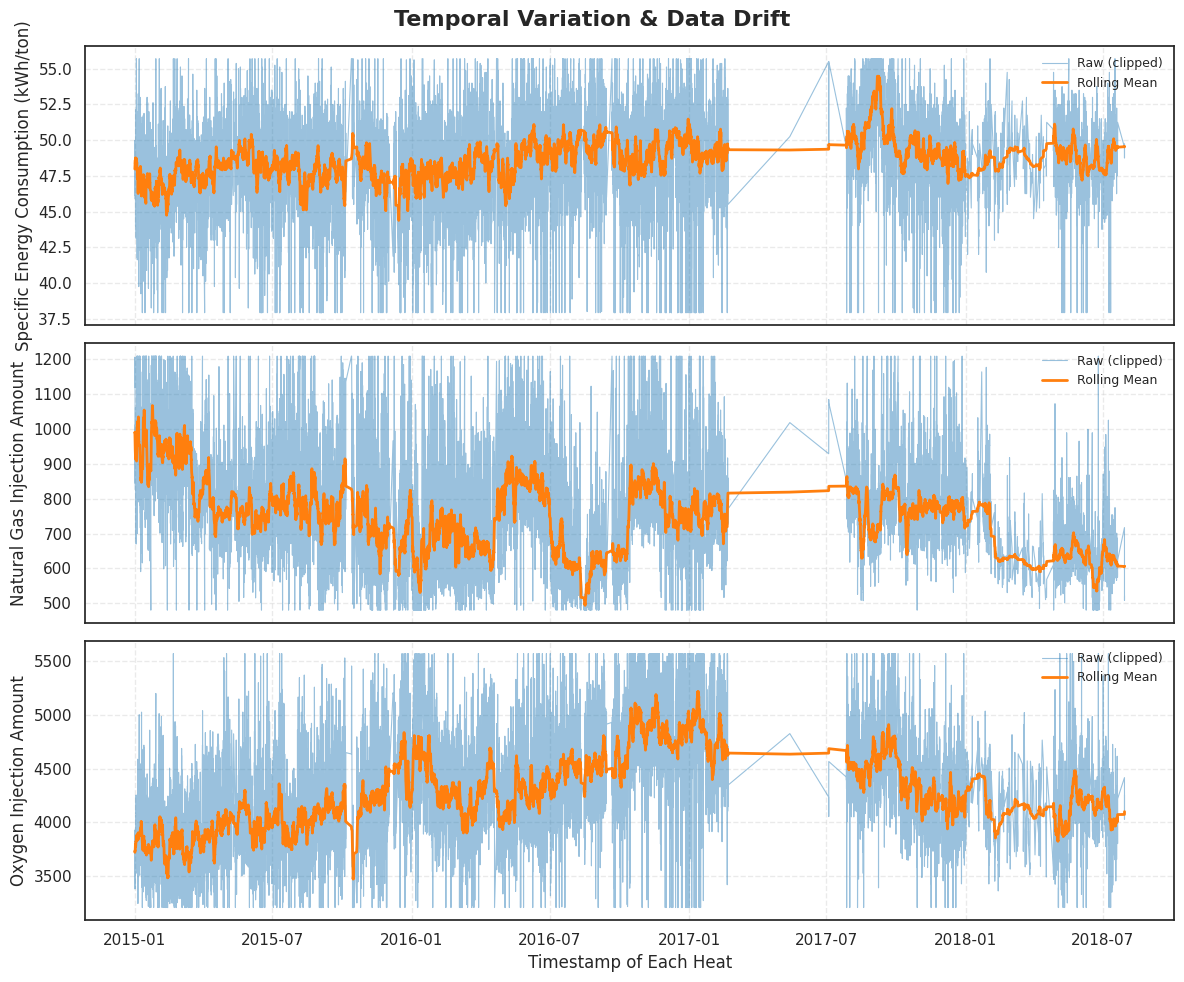

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Sort by timestamp to ensure correct time order
df_design_sorted = df_design.sort_values(by='DATETIME').reset_index(drop=True)

# Define variables to visualize
time_features = [
    ('MW', 'Specific Energy Consumption (kWh/ton)'),
    ('GAS_AMOUNT', 'Natural Gas Injection Amount'),
    ('O2_AMOUNT', 'Oxygen Injection Amount')
]

# outlier clip percentiles and rolling window (tune if needed)
CLIP_PCTS = (1, 99)      # remove extreme 1% tails
ROLL_WIN  = 50           # rolling-mean window length (in rows)

fig, axes = plt.subplots(len(time_features), 1, figsize=(12, 10), sharex=True)
fig.suptitle('Temporal Variation & Data Drift', fontsize=16, fontweight='bold')

for i, (col, title) in enumerate(time_features):
    ax = axes[i]
    x = df_design_sorted['DATETIME']
    y = df_design_sorted[col].astype(float)

    # ---- minimal outlier handling: percentile clipping (winsorization) ----
    lo, hi = np.nanpercentile(y.dropna(), CLIP_PCTS)
    y_clip = y.clip(lower=lo, upper=hi)

    # ---- original raw (clipped) line ----
    ax.plot(x, y_clip, linewidth=0.8, alpha=0.45, color='tab:blue', label='Raw (clipped)')

    # ---- rolling mean overlay ----
    y_roll = y_clip.rolling(ROLL_WIN, center=True, min_periods=max(5, ROLL_WIN//5)).mean()
    ax.plot(x, y_roll, linewidth=2.0, color='tab:orange', label='Rolling Mean')

    ax.set_ylabel(title)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='upper right', fontsize=9, frameon=False)

axes[-1].set_xlabel('Timestamp of Each Heat')
plt.tight_layout()
plt.show()




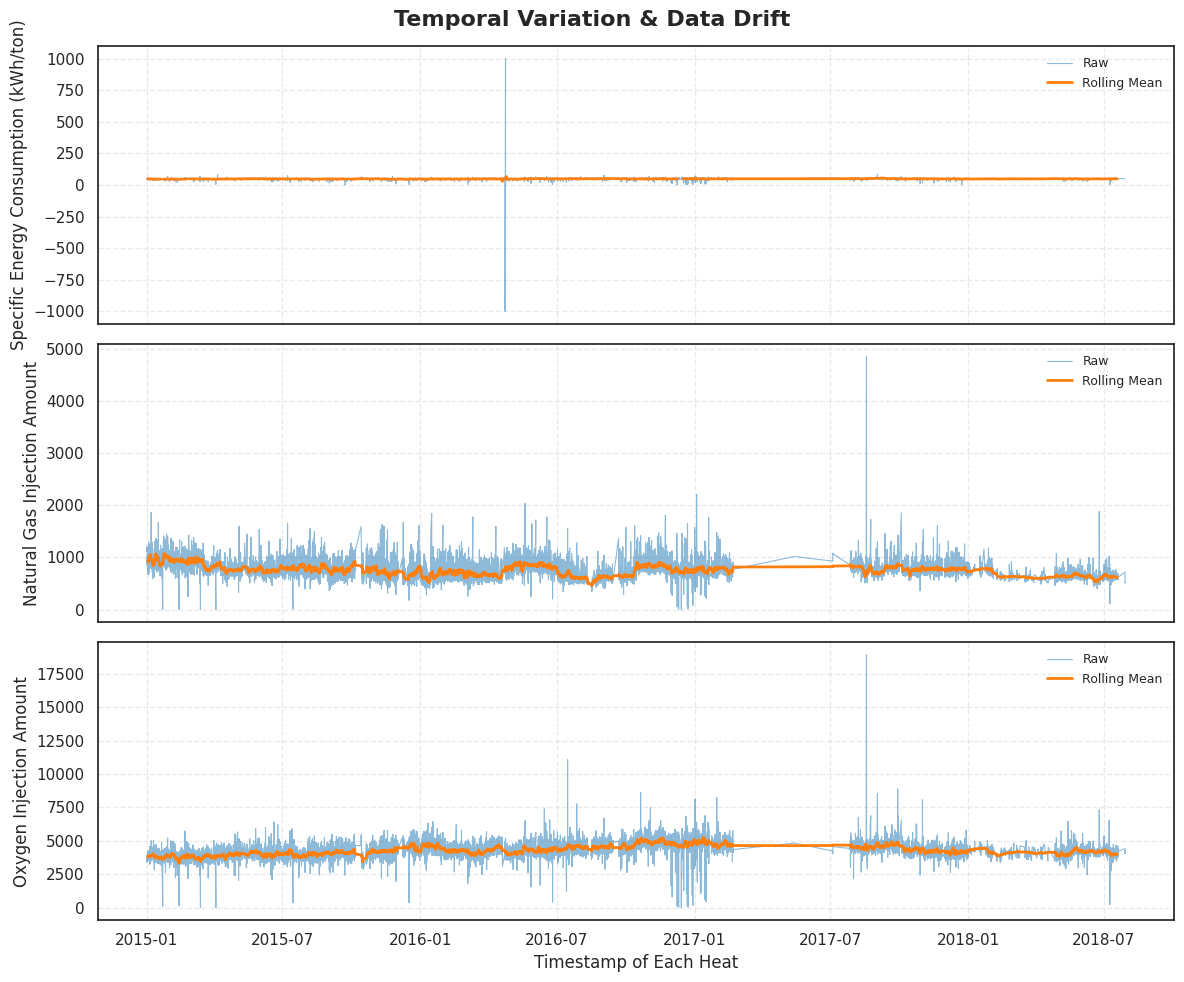

In [44]:
import matplotlib.pyplot as plt

# Sort by timestamp to ensure correct time order
df_design_sorted = df_design.sort_values(by='DATETIME').reset_index(drop=True)

# Define variables to visualize
time_features = [
    ('MW', 'Specific Energy Consumption (kWh/ton)'),
    ('GAS_AMOUNT', 'Natural Gas Injection Amount'),
    ('O2_AMOUNT', 'Oxygen Injection Amount')
]

# Rolling window length (tune if needed)
ROLL_WIN = 50

# Create subplots
fig, axes = plt.subplots(len(time_features), 1, figsize=(12, 10), sharex=True)
fig.suptitle('Temporal Variation & Data Drift', fontsize=16, fontweight='bold')

for i, (col, title) in enumerate(time_features):
    ax = axes[i]

    # Raw line
    ax.plot(df_design_sorted['DATETIME'], df_design_sorted[col],
            linewidth=0.8, alpha=0.5, color='tab:blue', label='Raw')

    # Rolling mean overlay
    ax.plot(df_design_sorted['DATETIME'],
            df_design_sorted[col].rolling(ROLL_WIN, center=True).mean(),
            linewidth=2, color='tab:orange', label='Rolling Mean')

    ax.set_ylabel(title)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='upper right', fontsize=9, frameon=False)

axes[-1].set_xlabel('Timestamp of Each Heat')
plt.tight_layout()
plt.show()
